## Soul of Reason - Demo

## <code style="background:pink;color:black"> Demo: Using the Jupyter Notebook

**1) Install required packages:**

    a) Clone the SOR Github
    b) In your terminal/command line, cd to the SOR Github directory
    c) Run "pip install -r requirements.txt" in the command line

**2) Import below packages:**

In [3]:
import glob
import os
import random
import spacy
import re
import warnings
import pandas as pd
from spacy import displacy
from tqdm import trange
from tqdm import tqdm
from itertools import chain
from pathlib import Path
from IPython.display import Image
from IPython.core.display import HTML 
! python -m spacy download en_core_web_sm   # You only need to run this once; you can comment it out after running

**3) Run NER class:**

     - Each function contains a docstring explaining what the function does, its inputs and outputs
     - There are also comments contained within each function explaining the purpose of the code

In [3]:
class NER:
    
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        
    def import_txt_files(self, path):
        """ 
        
        Loads a series of text files into Python. 
    
        Input
        -----------------------------------------
        path : string
            This is the directory path to your folder of text files. Note that the path must be in single ('') 
            or double ("") quotations. To avoid confusion during processing, this directory should only contain
            the text files that you want to analyze for entities.
        
            Example - 
        
                    '/Users/myusername/Desktop/soul-of-reason-as-data/data' 
                    (where /data is the folder containing all text files)


        Returns
        -----------------------------------------
        corpus : list 
            Returns a Python list of all of the text files, as well as the total number of documents in the corpus 
            (the number of text files in your folder).


        """
        
        print("Importing text files...")
        
        # Compile all text file names from working directory
        
        txt_files = glob.glob(os.path.join(os.getcwd(), path, "*.txt"))
        
        # Append each document to a list called corpus + error-handle

        corpus = []
        
        try:
            for individual_file in txt_files:
                with open(individual_file) as f_input:
                    corpus.append(f_input.read())
        except:
            print("ERROR: Could not import text files. Please ensure that you entered that correct directory path "+
                  "and that all of the files you want to analyze have a .txt extension.")
            
                
        # Return the number of documents in the corpus & the Python corpus list

        print("Number of documents in corpus: ",len(corpus))

        return corpus
    
    
    def remove_timestamps(self, docs):
        """
        
        Removes timestaps (i.e. - 'Dr. Roscoe C Brown 00:00:01.490') from text. This ensures that the model does 
        not repeatedly include these entities in the final dataset. 
        
        Input 
        -----------------------------------------
        text : list
            The list of documents you want to remove timestamps from; i.e. the output from import_txt_files().
            
            
        Returns
        -----------------------------------------
        docs : list
            The same list of documents from the input, except with all timestamps removed. 
        
        """
        
        print("Removing timestamps...")
        
        # Find all transcription lines using regex (must convert to string/non-list item first)
        
        text = ''.join(docs)
        lines = re.findall("[0-9][0-9].[0-9][0-9].[0-9][0-9].[0-9][0-9][0-9]*", text)
        
        # Error handle -- return message if there are no transcription lines to be found
        
        if len(lines) == 0:
            print("ERROR: No transcription lines have been found in the corpus. Did you remove them already? If so, "+
                 "you don't need to use this function and can skip to link_metadata.")
        else:
            
            # Split lines + replaced double-spaced lines with single spaced lines

            split = text.replace('\n\n','\n').splitlines() 

            # Append all of the transcription lines to a list

            lines_remove = []                  
            for i in split:
                for j in lines:
                    if j in i:
                        lines_remove.append(i)

            # Remove aforementioned trancription lines

            for i in range(len(docs)):          
                for j in lines_remove:
                    if j in docs[i]:
                        docs[i] = docs[i].replace(j,'')

            # Replace double-lines with single & triple lines with double

            for i in range(len(docs)):
                docs[i] = docs[i].replace('\n\n','')    

            print("Timestamps removed from corpus.")       
        
        return docs
    
    
    def link_metadata(self, docs, txt_path):
        """
        
        Links the text file name (e.g. 'RG_9_8_208.txt') to the corresponding text document in Python.

        NOTE: 
            - This function is dependent on the fact that each text file is named in a format similar to 
             'RG_9_8_208.txt' or 'RG9-8_ref4330.txt' (for example). Text files that do not meet either of 
              these naming formats will not be identified and an error will be thrown, with a reference to 
              the invalid document(s).

            - Please also ensure that the text files in your txt_path are only those you want to analyze 
              (i.e. no irrelevant text files).

            - Running this function multiple times in the same class instance will result in the metadata 
              being appended more than once. 

        Input
        -------------------------
        docs : list
            The list of all documents where metadata needs to be appended, i.e. the 'docs' output from 
            remove_timestamps(). The number of documents in this list should match the number of documents 
            imported after using import_txt_files().  

        txt_path : string
            The directory path on your computer where all .txt files are stored; this should be the same as that 
            used in import_txt_files(). Note that the path must be in single ('') or double ("") quotations.

            Example - 

            '/Users/myusername/Desktop/soul-of-reason-as-data/data' 
            (where /data is the folder containing all text files)

        Returns
        ------------------------
        docs : list
            The same list you inputted, except with an appended reference to the corresponding file name at the end 
            of every document, in the form of: <DOC_ID>: 'text file name.'

        """
        
        print("Adding metadata identifier to each document...\n\n")
        
        # Create list of text file names from txt_path
        
        txt_files = glob.glob(os.path.join(os.getcwd(), txt_path, "*.txt"))
        
        # Create four empty lists to collect the file names for each document
        # There are four lists because there are four 'types' of naming formats
        # l1 will be the final list (other lists will be merged into this one)
        # Therefore, make l1 a global variable because it will be used in another function

        global l1 
        l1 = []
        l2 = []
        l3 = []
        l4 = []

        # Find all names of text files using regex, following the given formats (mentioned in docstring)
        
        for i in range(len(txt_files)):   
            l1.append(re.findall('[A-Z][A-Z]\w[0-9]\w[0-9]\w[0-9][0-9][0-9]\W[a-z][a-z][a-z]',txt_files[i]))
            l2.append(re.findall('[A-Z][A-Z]\w[0-9]\w[0-9]\w[0-9][0-9]\W[a-z][a-z][a-z]',txt_files[i]))
            l3.append(re.findall('[A-Z][A-Z][0-9]\W[0-9]\w[a-z][a-z][a-z][0-9][0-9][0-9][0-9]\W[a-z][a-z][a-z]', txt_files[i]))
            l4.append(re.findall('[A-Z][A-Z][0-9]\w[0-9]\w[0-9][0-9][0-9]\W[a-z][a-z][a-z]',txt_files[i]))
        
        # Merge the lists of the text file names to get one complete list, l1
        
        for i in range(len(l1)):         
            if l1[i] == [] and l2[i] != []:
                l1[i] = l2[i]
            elif l1[i] == [] and l3[i] != []:
                l1[i] = l3[i]
            elif l1[i] == [] and l4[i] != []:
                l1[i] = l4[i]
            else:
                pass
            
        # Add the corresponding .txt file name to the end of each document (+ error handling)
        # A message will appear if files do not file the given naming format (as given by the digi_id of metadata)
        # A message will appear if you have extra text files in your directory path
        # This <DOC_ID> will be called to link the metadata file when creating the final dataset

        empties = []    
        if len(docs) == len(l1):
            for i in tqdm(range(len(docs))):
                docs[i] = docs[i] + ' <DOC_ID>: '+''.join(l1[i])
            print("Finished linking metadata. Each document in the corpus list contains a <DOC_ID> identifier on the last "\
                  "line, with its corresponding .txt file name.\n\n")
        else:
            if [] in l1:
                for i in range(len(l1)):
                    if l1[i] == []:
                        empties.append(i)
                    empty_docs = [txt_files[x] for x in empties]
                print("ERROR: One or more .txt document names could not be found. Please ensure that the names of all .txt "+
                "files follow the permitted naming format. Error comes from document(s): ",empties,empty_docs)
            else:
                print("ERROR: The number of text files in your directory path does not equal the number of text files imported!\n"+
                      "Please ensure there are no additional .txt files in the file path you supplied.\n\n")

        return docs
    

    def predict_entities(self, corpus):
        """
        
        Predicts entities in the given corpus. Entities are labelled according to spaCy entitiy types; see 
        https://spacy.io/api/annotation#named-entities for a list of all labels.
        
        NOTE:
            - Remember that this function has two outputs (described below). The next function takes only the FIRST
              ouptut of this function, therefore you will need to index this function's output by [0].
        
        Input
        ----------------------------------------
        corpus : list
            The list of documents to extract entities from; this should be the output from link_metadata().
            
        Returns
        ----------------------------------------
        preds : list
            A list of tuples in the form of [(Entity, Start_Index, End_Index, Entity_Label, Doc_ID)], predicted 
            by the spaCy model. This will be passed as input to the create_final_dataset() function.
            
        ents_only : list
            A list of *only* the predicted entities; includes duplicates and predicted entities from every document.
            This output is not used in any other function; it is returned as a supplementary list that could be 
            useful for further analysis in Python.
        
        """
        
        print("Predicting entitiies...")
        
        # Extract <DOC_ID> tokens & append to list, doc_ids
        # Use the index -17 because the <DOC_ID> token will be the very last token (hence, the negative)
        # 17 is used because, according to the given format, the longest document id would be 17 characters
        
        preds = []
        doc_ids = []
        ents_only = []
        
        for i in range(len(corpus)):
            doc = corpus[i]
            doc_id = doc[-17:]
            doc_ids.append(doc_id)
        
        # Remove extra characters from doc_ids list --> remove 'D>:' and '>:' which may have been included
        # ... becauase of the <DOC_ID> part
        # This applies to file names that are less than 17 characters 
        
        for i in range(len(doc_ids)):
            doc_ids[i] = doc_ids[i].replace('D>: ','')
            doc_ids[i] = doc_ids[i].replace('>: ','')
        
        # Predict entities, append information to a list called preds + error handling
        # Predictions made using spaCy's pre-trained model, which I named 'nlp' (see the init method) 
        
        try:
            for i in tqdm(range(len(corpus))):
                doc = corpus[i]
                preproc_doc = self.nlp(doc)
                for ent in preproc_doc.ents:
                    preds.append((ent.text, ent.start_char, ent.end_char, ent.label_, doc_ids[i]))
                    ents_only.append(ent.text)
        except:
            print("ERROR: Could not predict all entities. Please ensure you are using the correct input to this function.\n\n")


        return preds, ents_only

    
    def create_final_dataset(self, preds, metadata_path, *args):
        """
        
        Creates the final dataset of named entities, and downloads this dataset to your current working directory
        as both a csv and json file. 
        
        NOTE:
            - This function requires the column containing the text file names in the metadata file to be 
              called 'digi_id'
            - If you choose to include the *args option (see description below), note that it must come 
              after the 'metadata_path' argument. 
            - Remember that you should only be using the first output from predict_entities() as input to this
              function. This means you need to index the ouptut from predict_entities() by [0].
        
        Input
        ----------------------------------
        preds : list (required)
            The list of tuples in the form of [(Entity, Start_Index, End_Index, Entity_Label, Doc_ID)]. This should
            be the output from the predict_entities() function.
            
        metadata_path : string (required)
            The file path containing the metadata file of your corpus. Note that this should be the *file* path and 
            not the *folder* path. 
            
        *args : list (optional)
            The list of entity types you want to filter by. This is an optional argument that allows you to choose 
            which entity types you want to see; i.e. - ['PERSON', 'ORG'] will return/save a dataset containing only
            entities identified as a person or organization. 
            
        
        Returns
        ----------------------------------
        final_df : pandas DataFrame
            The final dataset of named entities, containing the entity, its start & end Python index, its entity 
            type, and all corresponding inputted metadata from the metadata file path.
            
        This function also returns both a csv and a json file with the same information as that in final_df above. 
        These datasets are automatically downloaded to your current working directory.
            
        """
        
        print("Creating final dataset...\n\n")
        
        # Make dataset, name columns
        
        cols = ['Entities','Start_index','End_index','Label','Doc_ID']
        df = pd.DataFrame(preds,columns=cols)
        
        # Drop 'DOC_ID' string & possible text file names picked up as entities
        # For example, 'RG_9_8_110' may be a record in the dataset labelled as CARDINAL
        
        df = df[~df['Entities'].isin(['DOC_ID'])]
        df = df[~df['Entities'].isin(l1)]
        
        # Drop '.txt' at the end of Doc_ID column, so that only the digi ids are reflected
        
        df['Doc_ID'] = df['Doc_ID'].replace(to_replace=r'\.txt', value='', regex=True)
        
        # Read in metadata file
        
        metadata = pd.read_csv(metadata_path)
        
        # Option to filter dataset by entitiy type
        
        if args:
            my_ents = list(chain(*args))
            try:
                df = df[df['Label'].isin(my_ents)]
            except:
                print("ERROR: could not filter by the inputted entitiy types. Please ensure each of your entity "+
                     "types is correct & exactly matches the spaCy formatting. See "+
                      "https://spacy.io/api/annotation#named-entities for a list of all available entity types.\n\n")
        
        # Link metadata file with entity dataset
        
        try:
            metadata = metadata.rename(columns={"digi_id":'Doc_ID'})
            final_df = pd.merge(df, metadata, how='inner', on='Doc_ID')
        except:
            print("ERROR: Could not link metadata to entity dataset. Please ensure that the column name 'digi_id' (the "+
                 "column containg the text file names), is present in the metadata file.\n\n")
        
        # Save dataset as csv to current directory
        
        final_df.to_csv('named_entities_csv.csv',index=False)
        final_df.to_json('named_entities_json.json', orient='columns')
        
        print("The named entity datastets, 'named_entities_csv' and 'named_entities_json', have been saved to your "+
              "current working \ndirectory.\n\n")
        
        # Give number of unique labels identified
        
        print("\nNumber of unique entities identified:",len(final_df['Entities'].unique()),"\n\n\nNumber of entities "+ 
              "identified, by entitiy type:\n",final_df['Label'].value_counts())
         
        return final_df
        
    
    def display_entities(self, path, *args): 
        """
        Displays highlighted entities of a specific document, with the option to view only specific entitiy types.
        
        NOTE: 
        
            - If you decide to export the Jupyter notebook, the visualizations are included as HTML.
            
            - If you choose to include the *args option, note that it must come after the 'path' argument. 
        
        Input
        -------------------
        path : string (required)
            The *file* path of the specific document you want to view. Note that the file path must be in 
            single ('') or double ("") quotations.
            
            Example - 
            
            '/Users/myusername/Desktop/soul-of-reason-as-data/data/RG_9_8_110.txt'
            
        *args : list (optional)
            The list of entity types you would like to view/filter. If you do not include this argument, the
            visualization will include all entity types. 
            
            Example - 
                
                To view only the 'Person','Organization', and 'Date' entity types, you would enter:
                ['PERSON', 'ORG', 'DATE']
                
                Please see https://spacy.io/api/annotation#named-entities for the complete list of entity types.
                Note that all entity-types must be comma-separated, in (single or double) quotations and typed 
                exactly as shown in the provided link. To view only one entity type, simply enter, for example:
                ['PERSON']
            
        Returns
        -------------------
        html : HTML
            HTML visualization of the document with all entities highlighted.
        
        """
        # Read in text file 
        
        corpus = []
        with open(path) as f_input:
            corpus.append(f_input.read())
        
        # Predict entities 
        
        txt = ''.join(corpus)
        txt2 = self.nlp(txt)
        
        global html
        
        # Filter by entitiy type(s) if 'args' argument is passed, return visualization (+ error handling)
        
        if args:
            ents = args[0]
            if type(ents) != list:
                print("ERROR: Cannot produce visualization. Please ensure you are entering the entities in a list format.\n"+
                "Example- ['PERSON','NORP','FAC']. See: https://spacy.io/api/annotation#named-entities for a complete list of entity \n"+
                      "types & enter them in a comma-separated list format with quotations.")
                
            else:
                try:
                    options = {"ents": ents}
                    txt2.user_data["title"] = "Entities for:", path
                    html = displacy.render(txt2, style="ent",options=options, page=True, minify=True)
                except:
                    print("ERROR: Cannot produce visualization. Please ensure the entities you specified are correctly entered.\n"+
                          "See: https://spacy.io/api/annotation#named-entities for a complete list of entity types & \n"+
                          "enter them in a comma-separated list format with quotations (example- ['PERSON','NORP','FAC']).")
        else:
            txt2.user_data["title"] = "Entities for:", path
            html = displacy.render(txt2, style="ent", page=True, minify=True)
        
        return html
    

** 4) Instantiate Class**

In [4]:
nlp1 = NER()

**5) Run functions in the following order:**
    
    a) import_txt_files
    b) remove_timestamps
    c) link_metadata
    d) predict_entities
    e) create_final_dataset
    
*display_entities is an optional visualizer and a stand-alone function*

***--------------------------------------------------------------------------------------***

### Function Description

<code style="background:yellow;color:black">a) ***import_txt_files***

`Loads a series of text files into Python.`

**Input** $\rightarrow$ The *directory* path of your text files. Note that the file path must be in single ('') or double ("") quotations.

**Returns** $\rightarrow$ List of all of the text files, as well as the total number of documents in the corpus (the number of text files in your folder).



In [5]:
text = nlp1.import_txt_files('/Users/nylaennels/Desktop/soul-of-reason-as-data/data')

Importing text files...
Number of documents in corpus:  52


<code style="background:yellow;color:black">b) ***remove_timestamps***

`Removes timestaps (i.e. - 'Dr. Roscoe C Brown 00:00:01.490') from text. This ensures that the model does not repeatedly include these entities in the final dataset.`

**Input** $\rightarrow$ The list of documents you want to remove timestamps from. This is just the output from *import_txt_files*.

**Returns** $\rightarrow$ The list of documents from the input, with all timstamps removed. 
        

In [6]:
clean_text = nlp1.remove_timestamps(text)

Removing timestamps...
Timestamps removed from corpus.


<code style="background:yellow;color:black">c) ***link_metadata***

`Links the text file name (e.g. 'RG_9_8_208.txt') to the corresponding text document in Python.`

`NOTE:`
- This function is dependent on the fact that each text file is named in a format similar to 'RG_9_8_208.txt' or 'RG9-8_ref4330.txt' (for example). Text files that do not meet either of these naming formats will not be identified and an error will be thrown, with a reference to the invalid document(s).
      
- Please also ensure that the text files in your txt_path are only those you want to analyze (i.e. no irrelevant text files).
     
- Running this function multiple times will result in the metadata being appended more than once.

**Input:**

1) The list of all documents where metadata needs to be appended, i.e. the 'docs' output from *remove_timestamps*.

2) The folder path on your computer where all .txt files are stored; this should be the same as that used in *import_txt_files*. Note that the file path must be in single ('') or double ("") quotations.


**Returns** $\rightarrow$ The same list you inputted, except with a reference to the filename appended at the end of every document in the list, in the form of: <br> $<$DOC_ID$>$: "text file name."

In [7]:
met_text = nlp1.link_metadata(clean_text, '/Users/nylaennels/Desktop/soul-of-reason-as-data/data')

100%|██████████| 52/52 [00:00<00:00, 19825.82it/s]

Adding metadata identifier to each document...


Finished linking metadata. Each document in the corpus list contains a <DOC_ID> identifier on the last line, with its corresponding .txt file name.




<code style="background:yellow;color:black">d) ***predict_entities***

`Predicts entities in the given corpus.`

**Input:** $\rightarrow$ The list of documents to extract entities from; this should be the output from *link_metadata*.

**Returns:**

1) The list of tuples in the form of **[(Entity, Start_Index, End_Index, Entity_Label, Doc_ID)]**, predicted by the spaCy model. This will be passed as input to the *create_final_dataset* function.

2) A list of *only* the predicted entities; includes duplicates and predicted entities from every document. This is not used in any other function; it is returned as a supplementary list that could be 
            useful for further analysis in Python.

In [8]:
ents = nlp1.predict_entities(met_text)

  0%|          | 0/52 [00:00<?, ?it/s]

Predicting entitiies...


100%|██████████| 52/52 [01:16<00:00,  1.48s/it]


<font color='red'> ***Note: You will need to index this output by [0] to use it as the input to create_final_dataset(), see red note below.***

<code style="background:yellow;color:black">e) ***create_final_dataset***

`Creates the final dataset of named entities, and downloads this dataset to your current working directory as a csv file.`

`NOTE:`

- This function requires the column containing the text file names in the metadata file to be called 'digi_id.'

**Input**:  
1) The list of tuples in the form of [(Entity, Start_Index, End_Index, Entity_Label, Doc_ID)]. This is the output from the *predict_entities* function.

2) The file path containing the metadata file of your corpus. Note that this should be the *file* path and not the *folder* path.

3) *OPTIONAL* - The list of entity types you want to filter by; i.e. - ['PERSON', 'ORG'] will return a dataset containing only entities identified as a person or organization. 


**Returns** $\rightarrow$ The final dataset of named entities, containing the entity, its start & end Python index, its entity type, and all corresponding inputted metadata from the metadata file path.

<font color='red'> ***IMPORTANT!! : Be sure to index input #1 by [0]! Remember that predict_entities has two outputs, and we only want to use the first one as our input here (hence, index by [0]).*** 

In [9]:
# Non-filtered final dataset
df = nlp1.create_final_dataset(ents[0],'/Users/nylaennels/Desktop/soul-of-reason-as-data/transcript_metadata_2020-09-22.csv')

Creating final dataset...


The named entity datastets, 'named_entities_csv' and 'named_entities_json', have been saved to your current working 
directory.



Number of unique entities identified: 3559 


Number of entities identified, by entitiy type:
 ORG            1783
PERSON         1760
CARDINAL       1272
GPE            1204
DATE           1195
NORP            754
WORK_OF_ART     551
LOC             366
TIME            305
ORDINAL         264
FAC             239
PERCENT          89
MONEY            86
EVENT            75
LANGUAGE         38
QUANTITY         27
LAW              17
PRODUCT          13
Name: Label, dtype: int64


In [10]:
df.head()

,Entities,Start_index,End_index,Label,Doc_ID,title,description,date,transcriber name,transcript status
0,Police Athletic League,5,27,ORG,RG_9_8_110,"Ford, Connie -- Executive Director of the Poli...","Dr. Roscoe C. Brown, Jr. and Connie Ford discu...",1977-06-22,Ellen Noonan,Finished
1,"over 60,000",35,46,CARDINAL,RG_9_8_110,"Ford, Connie -- Executive Director of the Poli...","Dr. Roscoe C. Brown, Jr. and Connie Ford discu...",1977-06-22,Ellen Noonan,Finished
2,New York City,47,60,GPE,RG_9_8_110,"Ford, Connie -- Executive Director of the Poli...","Dr. Roscoe C. Brown, Jr. and Connie Ford discu...",1977-06-22,Ellen Noonan,Finished
3,winter,87,93,DATE,RG_9_8_110,"Ford, Connie -- Executive Director of the Poli...","Dr. Roscoe C. Brown, Jr. and Connie Ford discu...",1977-06-22,Ellen Noonan,Finished
4,summer months,98,111,DATE,RG_9_8_110,"Ford, Connie -- Executive Director of the Poli...","Dr. Roscoe C. Brown, Jr. and Connie Ford discu...",1977-06-22,Ellen Noonan,Finished


In [11]:
# An example of filtering by entitiy types PERSON & ORG
filtered_df = nlp1.create_final_dataset(ents[0], '/Users/nylaennels/Desktop/soul-of-reason-as-data/transcript_metadata_2020-09-22.csv', 
                                       ['PERSON','ORG'])

Creating final dataset...


The named entity datastets, 'named_entities_csv' and 'named_entities_json', have been saved to your current working 
directory.



Number of unique entities identified: 1610 


Number of entities identified, by entitiy type:
 ORG       1783
PERSON    1760
Name: Label, dtype: int64


In [12]:
filtered_df.head()

,Entities,Start_index,End_index,Label,Doc_ID,title,description,date,transcriber name,transcript status
0,Police Athletic League,5,27,ORG,RG_9_8_110,"Ford, Connie -- Executive Director of the Poli...","Dr. Roscoe C. Brown, Jr. and Connie Ford discu...",1977-06-22,Ellen Noonan,Finished
1,Connie Ford,118,129,PERSON,RG_9_8_110,"Ford, Connie -- Executive Director of the Poli...","Dr. Roscoe C. Brown, Jr. and Connie Ford discu...",1977-06-22,Ellen Noonan,Finished
2,PAL,157,160,ORG,RG_9_8_110,"Ford, Connie -- Executive Director of the Poli...","Dr. Roscoe C. Brown, Jr. and Connie Ford discu...",1977-06-22,Ellen Noonan,Finished
3,the WNBC Community Affairs Department,341,378,ORG,RG_9_8_110,"Ford, Connie -- Executive Director of the Poli...","Dr. Roscoe C. Brown, Jr. and Connie Ford discu...",1977-06-22,Ellen Noonan,Finished
4,the Institute of Afro-American Affairs,400,438,ORG,RG_9_8_110,"Ford, Connie -- Executive Director of the Poli...","Dr. Roscoe C. Brown, Jr. and Connie Ford discu...",1977-06-22,Ellen Noonan,Finished


<code style="background:yellow;color:black">f) ***display_entities*** : optional visualizer

`Displays highlighted entities of a specific document, with the option to view only specific entitiy types.`

**Input**:

1) The *file* path of the specific document you want to view. Note that the file path must be in single ('') or double ("") quotations.

2) *OPTIONAL* The list of entity types you would like to view/filter. If you do not include this argument, the visualization will include all entity types. Example - To view only the 'Person','Organization', and 'Date' entity types, you would enter:['PERSON', 'ORG', 'DATE']. 

**Returns**$\rightarrow$ Visualization of the document with all entities highlighted.

In [13]:
# Non-filtered visualization
vis = nlp1.display_entities('/Users/nylaennels/Desktop/soul-of-reason-as-data/data/RG_9_8_115.txt')
vis

In [14]:
# Filter visualization to only see PERSON & NORP entitiy types
filt_vis = nlp1.display_entities('/Users/nylaennels/Desktop/soul-of-reason-as-data/data/RG_9_8_115.txt',['PERSON','NORP'])
filt_vis

## Looking at the Intermediate Output from Each Function ...

- `After using import_txt_files():`

In [15]:
# The entire corpus
# text

In [16]:
# Example of one document 
# text[0]

- `After using remove_timestamps():`

In [17]:
# The entire corpus
# clean_text

In [18]:
# Example of one document
# text[0]

- `After using link_metadata():`

In [19]:
# The entire corpus
# met_text

In [20]:
# Example of one document
# met_text[0]

- `After using predict_entities():`

In [21]:
# First output
# ents[0]

In [22]:
# Other output
# ents[1]

----------------------------------------------------------------------------------

# <code style="background:pink;color:black"> Demo: Running the Script

1) Download the 'SOR_SCRIPT.py' file to your preferred file location (or clone the SOR Github repo)

2) Open your command line & cd into the location where you saved the script (or repository)

3) Run 'python3 SOR_SCRIPT.py' in command line

4) First, you will be asked to enter the folder path to your text files

5) The script will then import the text files, remove the timestamps, link the text file names, and predict entities. You will then be asked to input the file path to your metadata

6) Finally, the script will create the final dataset, download the csv & json files to your working directory and return some statistics on the number of entities identified

    - Note: In Macs, you can copy a file or folder's exact location by holding down the control button & clicking
     the file or folder, and then pressing 'option.' You should see an option that says 'Copy [filename] as 
     Pathname'; this will copy your highlighted file or folder's location on your computer.

##### Example:

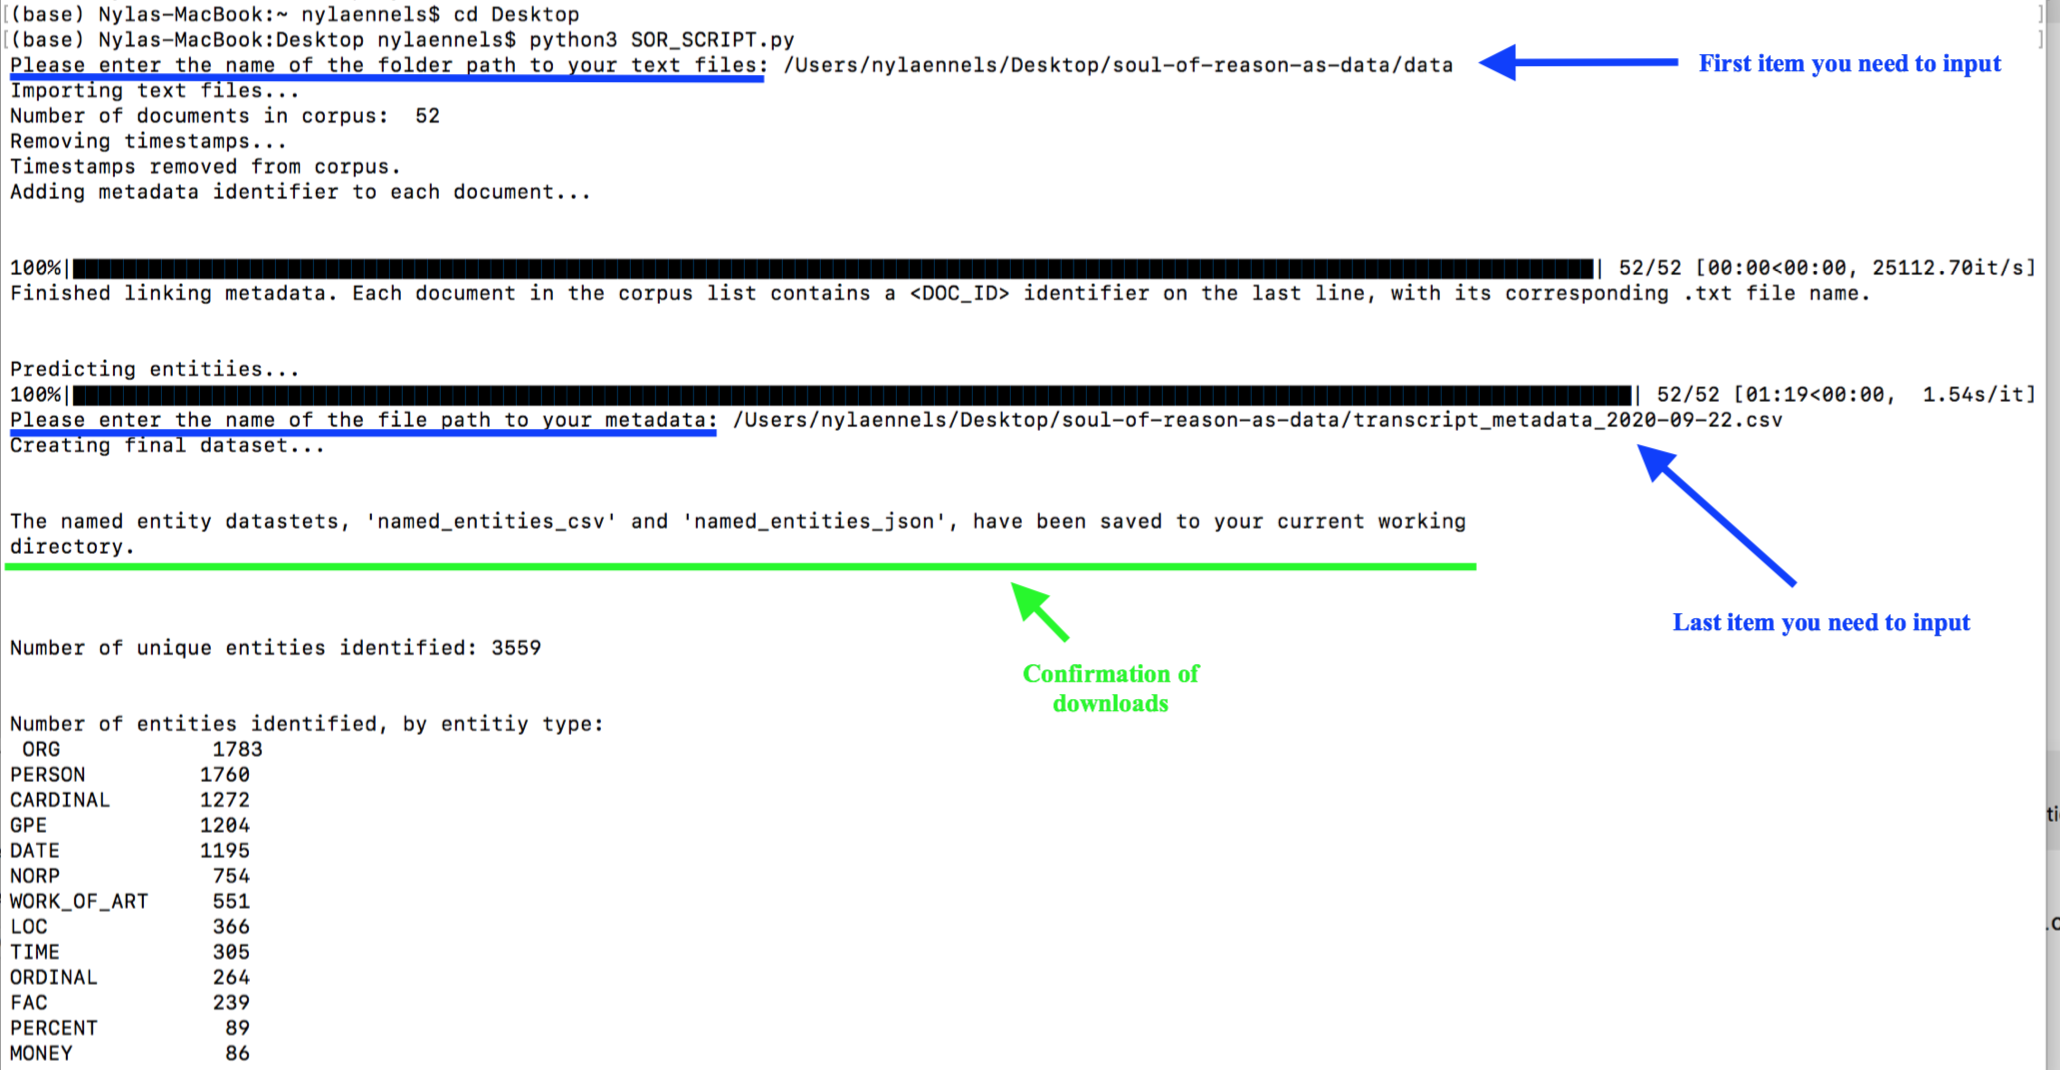

In [27]:
Image("/Users/nylaennels/Desktop/ss0.png")

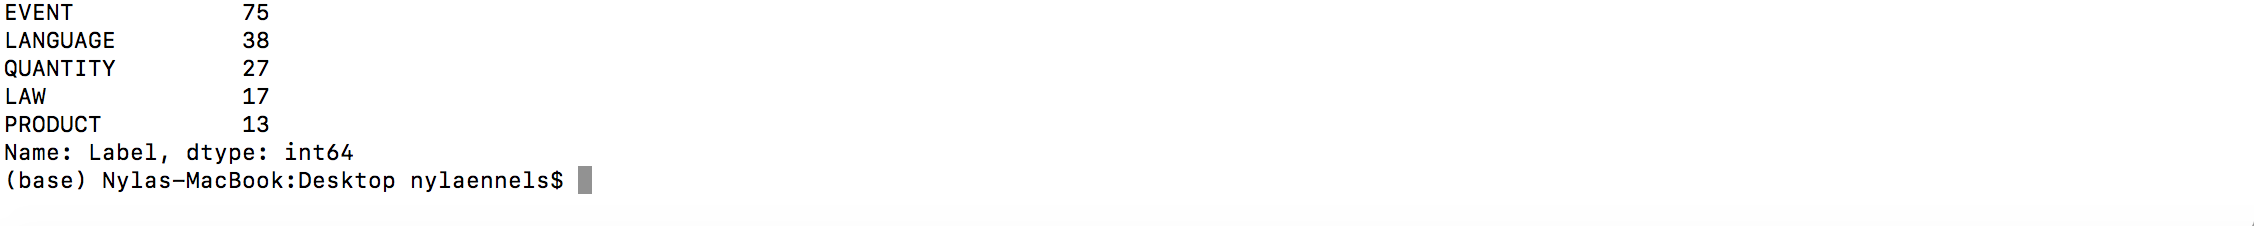

In [26]:
Image("/Users/nylaennels/Desktop/ss1.png")

#### Files downloaded to working directory from script:

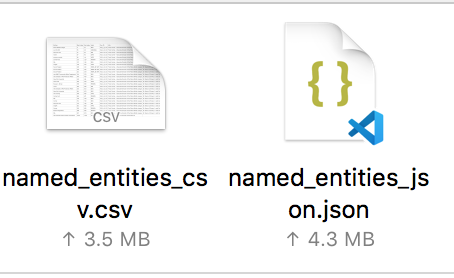

In [23]:
Image("/Users/nylaennels/Desktop/ss.png")

# <code style="background:pink;color:black"> Demo: Using the Streamlit App

### 1) In your command line, cd into the location where you have the 'app.py' file saved (or cd into the Github repository if you've cloned it)

### 2) Run "streamlit run app.py" in your command line
    
- Note: if an error appears here, you may need to upgrade the protobuf package: run "pip install --upgrade protobuf" and then try again
    
- You may see the following screen if you have not used streamlit before:

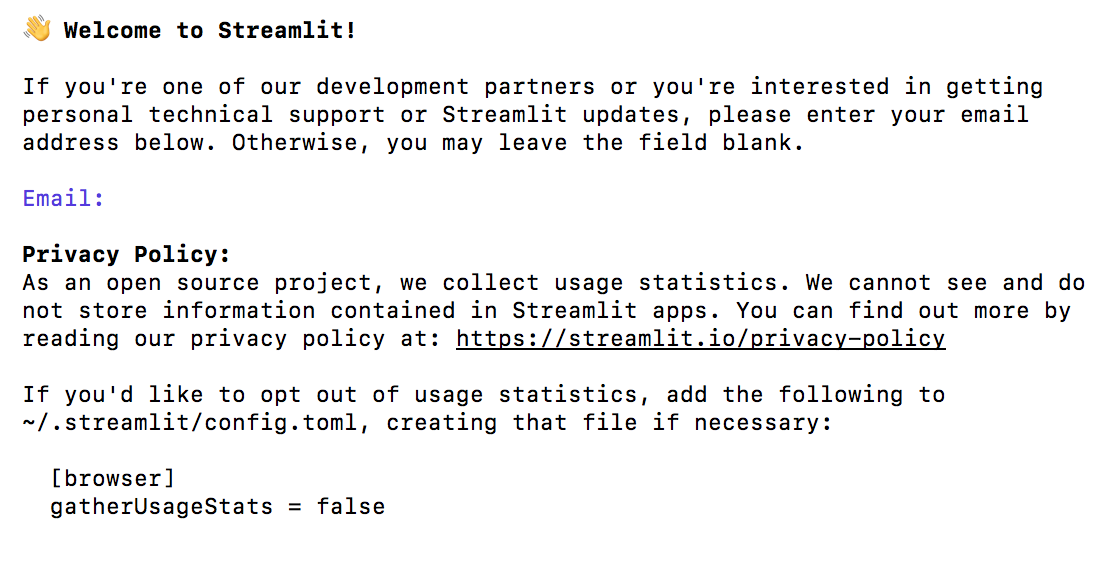

In [4]:
Image("/Users/nylaennels/Desktop/app_ss.png")

- Simply press enter to continue if you see this screen

### 3) The app should then automatically load in your browser:

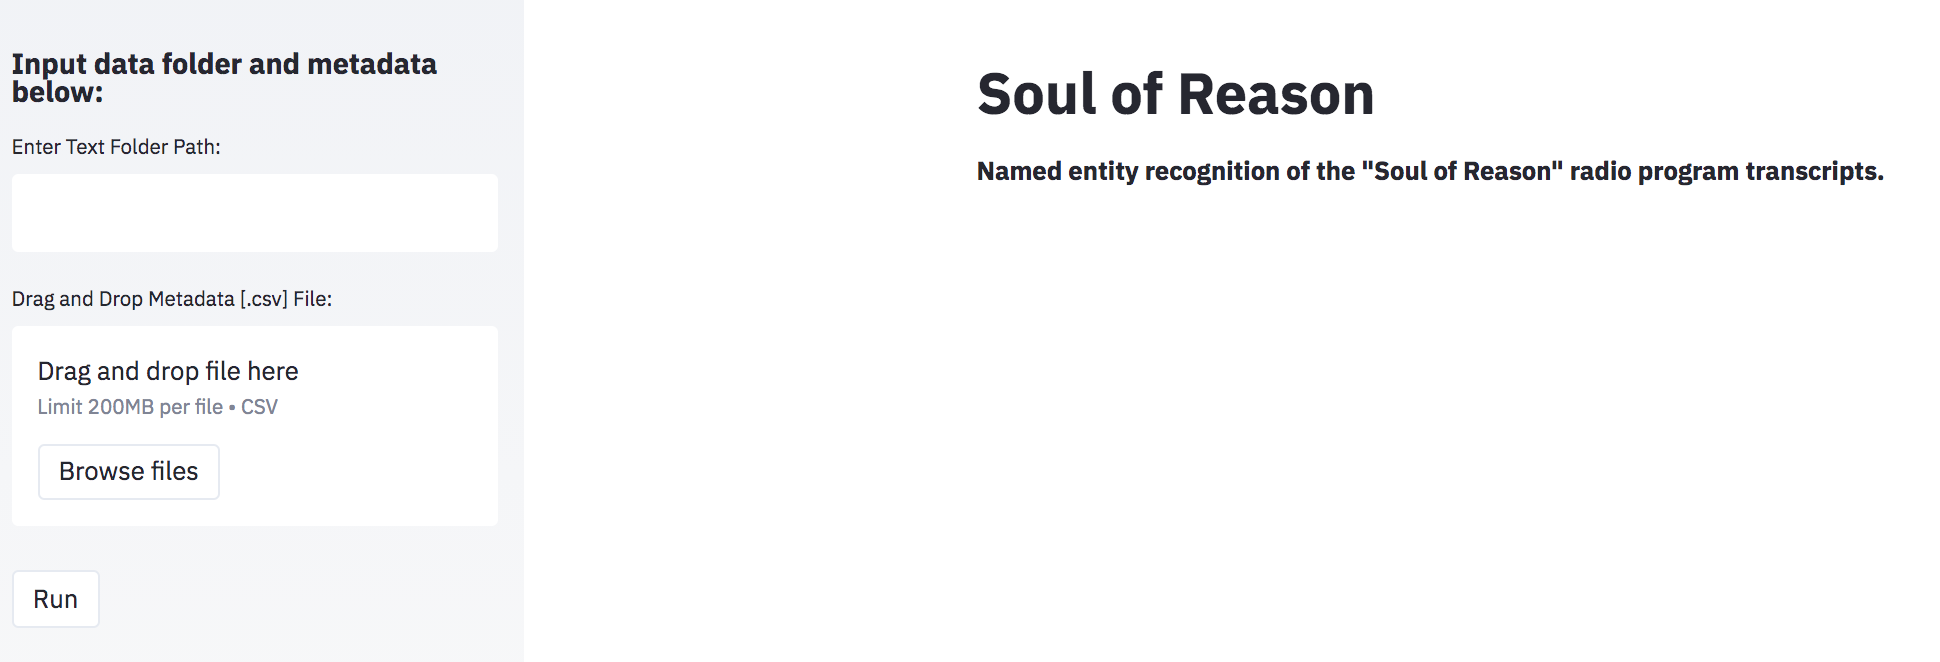

In [5]:
Image("/Users/nylaennels/Desktop/app_blank.png")

### 4) Enter the text folder path in the first box. Drag/select the metadata file in the second box & then press run.

### 5) You should see the following progress bars:

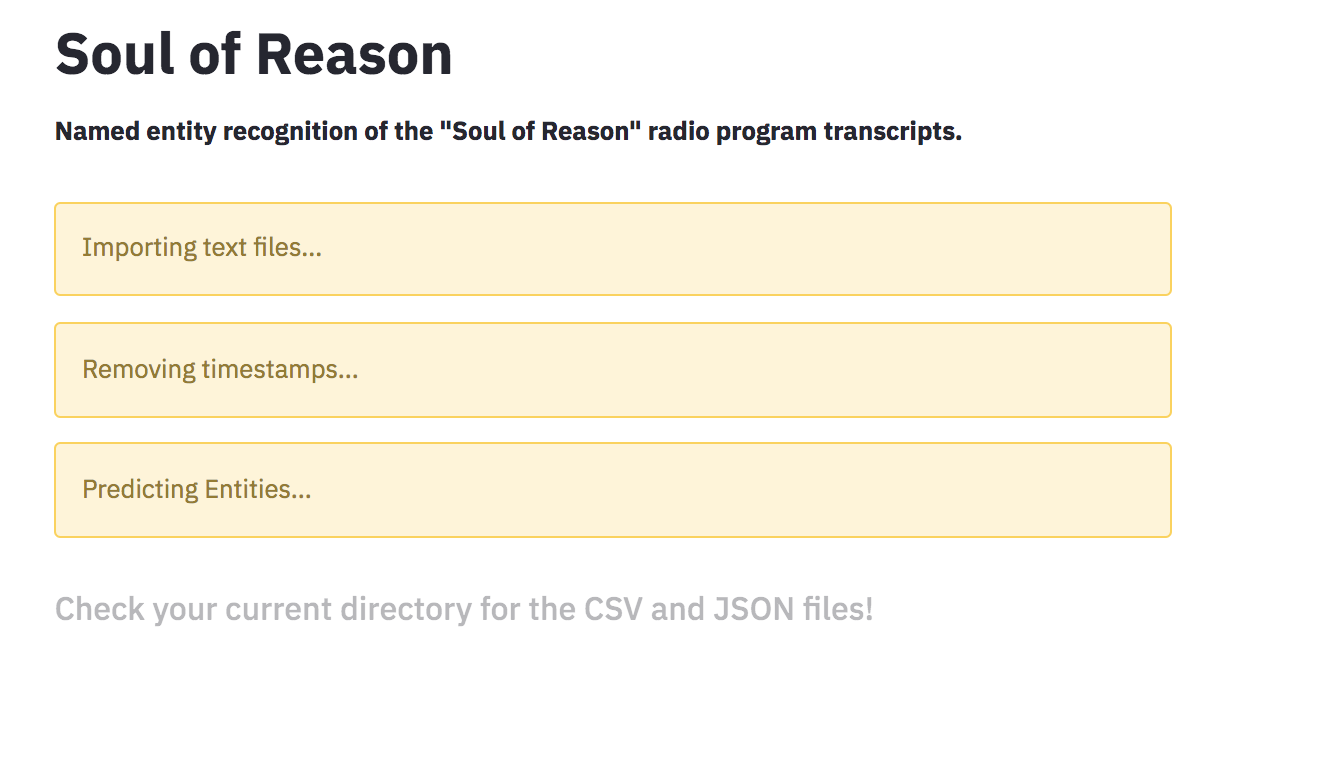

In [6]:
Image("/Users/nylaennels/Desktop/Screen Shot 2020-12-14 at 4.21.19 PM.png")

### 6) When the process is completed, you will see the following confirmation:

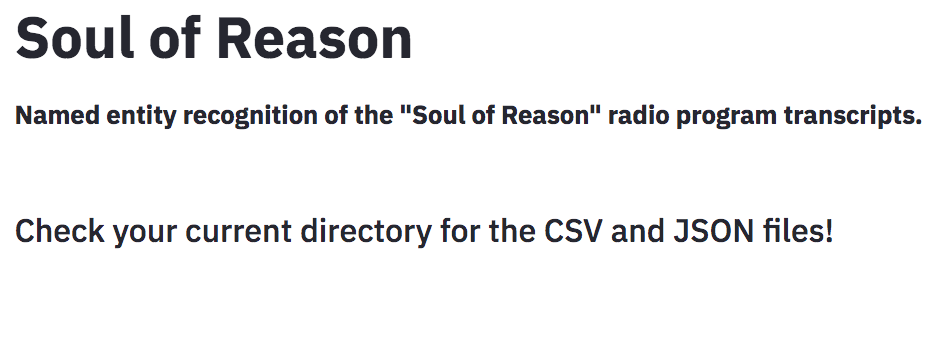

In [9]:
Image("/Users/nylaennels/Desktop/Screen Shot 2020-12-14 at 4.26.07 PM.png")